In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import pprint
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import json
import models
from plot_configs import plot_configs

In [2]:
''' choose the transformer architecture hyperparameters  '''
model_str = 'gpt3_1T'  # what model? choose from models.py (gpt3_1T, vit_era5) 
model = models.models[model_str]
# set model hyperparams
l = model['l']
e = model['e']
f = 4 * e
model['f'] = f
h = model['h']
depth = model['depth']
print('model is {}'.format(model))

'''set some dataset size hyperparameters 
   if LLMs, it's number of tokens, else
   it's number of samples in ERA5.     '''

if model_str == 'gpt3_1T':
    total_tokens = 1 * 10**12
else:
    total_tokens = 300 * 10**9
    
num_samples = total_tokens / l
if 'vit_era5' in model_str:
    num_ep = 80
    num_samples = 350000 * num_ep
print('training on {} samples'.format(num_samples))
global_batch_size = 4096

model is {'l': 2048, 'e': 25600, 'h': 160, 'depth': 128, 'f': 102400}
training on 488281250.0 samples


In [3]:
''' sweep through different systems with different GPUs and different NVS sizes '''
systems = ['A100-NVS4', 'A100-NVS8', 'A100-NVS64', 'H200-NVS4', 'H200-NVS8', 'H200-NVS64', 'B200-NVS4', 'B200-NVS8', 'B200-NVS64']
config_names = ['A100', 'A100', 'A100', 'H200', 'H200', 'H200', 'B200', 'B200', 'B200']
nvlink_sizes = [4, 8, 64, 4, 8, 64, 4, 8, 64] # nvs sizes

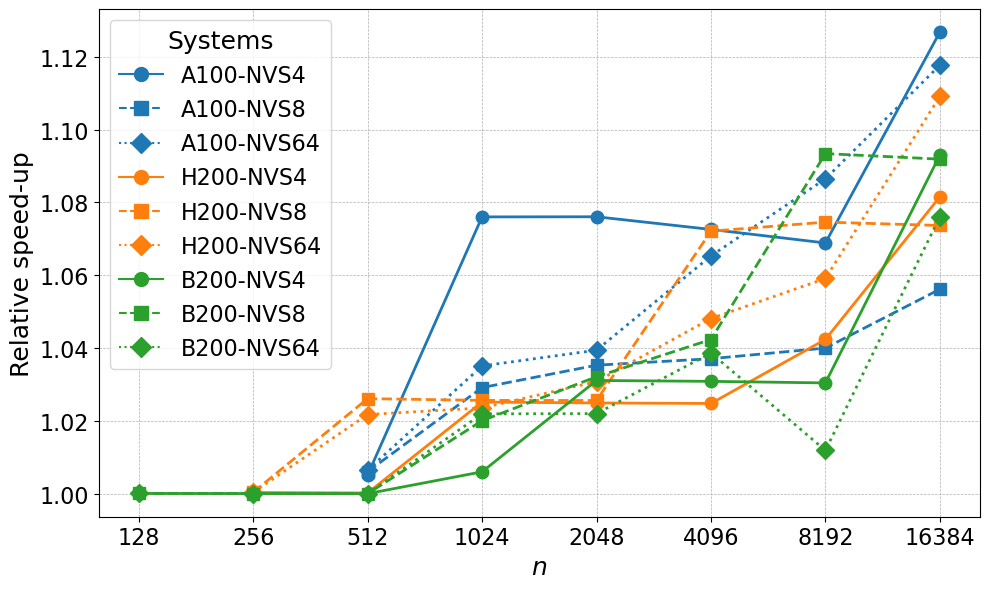

In [4]:
styles = ['o', 's', 'D']  # Different markers for NVS sizes
line_styles = ['-', '--', ':']  # Different line styles for NVS sizes
st_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Different colors for GPU types
parallel_strat_pairs = [('2d-seqp', '1d')]  # Replace with your actual strategy names
unique_gpus = ['A100', 'H200', 'B200']

fig, axs = plt.subplots(1, 1, figsize=(10, 6), tight_layout=True)
axs.tick_params(axis='both', which='major', labelsize=16)
axs.tick_params(axis='both', which='minor', labelsize=16)

sys_str_handles = []
gpu_count_to_read = 4096  # Print times at this #gpus to check
feasible = False

# Outer loop for the two parallel strategies
for strat1, strat2 in parallel_strat_pairs:
    times_strat1 = {}
    times_strat2 = {}
    n_gpus_strat1 = {}
    n_gpus_strat2 = {}
    
    for st, sys_str in enumerate(systems):
        gpu_type = config_names[st]
        nvs_size = nvlink_sizes[st]
        
        # Use color based on GPU type, marker and line style based on NVS size
        color = st_colors[unique_gpus.index(gpu_type)]  # Color based on GPU type
        marker = styles[nvlink_sizes.index(nvs_size) % len(styles)]  # Marker based on NVS size
        linestyle = line_styles[nvlink_sizes.index(nvs_size) % len(line_styles)]  # Line style based on NVS size

        # Load data for the first strategy
        x1 = np.load('../outputs/exec_{}_{}_{}.npy'.format(strat1, model_str, sys_str), allow_pickle=True)
        x2 = np.load('../outputs/exec_{}_{}_{}.npy'.format(strat2, model_str, sys_str), allow_pickle=True)

        nvc = 0
        
        # Process the first strategy data
        for nvs, t_max, t_min, n_gpus, configs in x1:
            if len(t_max) == 0:
                continue
            feasible = True
            time_strat1 = [(num_samples / tm) / (3600 * 24) for tm in t_max]
            times_strat1[sys_str] = time_strat1
            n_gpus_strat1[sys_str] = n_gpus  # Store the n_gpus for strat1
        
        # Process the second strategy data
        for nvs, t_max, t_min, n_gpus, configs in x2:
            if len(t_max) == 0:
                continue
            time_strat2 = [(num_samples / tm) / (3600 * 24) for tm in t_max]
            times_strat2[sys_str] = time_strat2
            n_gpus_strat2[sys_str] = n_gpus  # Store the n_gpus for strat2

        if sys_str in times_strat1 and sys_str in times_strat2:
            # Find the intersection of n_gpus for strat1 and strat2
            common_gpus = sorted(set(n_gpus_strat1[sys_str]) & set(n_gpus_strat2[sys_str]))
            if len(common_gpus) == 0:
                print(f"No common GPU counts for {strat1} and {strat2} on {sys_str}")
                continue

            # Align the time data with the common GPU counts
            time_strat1_common = [times_strat1[sys_str][list(n_gpus_strat1[sys_str]).index(gpu)] for gpu in common_gpus]
            time_strat2_common = [times_strat2[sys_str][list(n_gpus_strat2[sys_str]).index(gpu)] for gpu in common_gpus]

            # Compute the ratio of training times for the common GPUs
            time_ratio = np.array(time_strat2_common) / np.array(time_strat1_common)

            # Plot the ratio of training times with different marker, color, and linestyle
            line, = axs.plot(common_gpus, time_ratio, label=f'{sys_str}: {strat2}/{strat1}', 
                             marker=marker, markersize=9, color=color, linewidth=2, linestyle=linestyle)

        axs.set_xscale('log', base=2)
        axs.set_xticks(common_gpus)
        axs.set_xticklabels(common_gpus)
        axs.set_xlabel(r'$n$', fontsize=18)
        axs.set_ylabel(f'Relative speed-up', fontsize=18)
        nvc += 1

        sys_str_handles.append(Line2D([0], [0], marker=marker, color=color, label=f'{sys_str}', linestyle=linestyle, markersize=10))

if not feasible:
    print('No feasible configs!')

# Add legends
sys_str_legend = axs.legend(handles=sys_str_handles, title="Systems", fontsize=16, loc='upper left', title_fontsize=18)
axs.grid(True, which='both', linestyle='--', linewidth=0.5)
fig.tight_layout()
# plt.show()
# plt.savefig('../outputs/compare_{}_{}_{}.pdf'.format(strat2, strat1, model_str), dpi=400)